# Recipe: Time Series Forecasting

## Overview

The Engine provides a simple toolset that allows users to forecast the future behavior of timeseries data using a Trainee.

## Recipe Goals

This recipe will demonstrate how to leverage Howso Engine's time series tools to forecast time-series data.

In [1]:
import warnings

from IPython.display import Markdown, display
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Step 1: Load Data

For this recipe, we use simulated data of a projectile that is launched vertically in the air with a randomly generated initial velocity. Then its height is calculated for each time step as gravity affects the vertical velocity until it hits the ground (height <= 0).

Additionally, we make sure that some of these series end early. We will use these unfinished series to demonstrate the ability to forecast series until their end.

In [2]:
cases = 200
max_initial_velocity = 22
min_initial_velocity = 8
dt = 0.1
gravity = 10

data = []
unfinished_ids = []

for i in range(cases):
    id = i
    dy = min_initial_velocity + np.random.random() * (max_initial_velocity - min_initial_velocity)
    time = 0
    y = 0
    stop_time = 0.75 + np.random.rand() * 2

    while y >= 0:
        data.append([id, time, y])
        dy -= 10 * dt
        y += dy
        time += dt

        if id % 20 == 0 and time > stop_time:
            unfinished_ids.append(id)
            break
    data.append([id, time, y])

df = pd.DataFrame(data, columns=['id', 'time', 'y'])

Here we plot the data. All the finished series are shown in pink and the unfinished series are shown in blue.

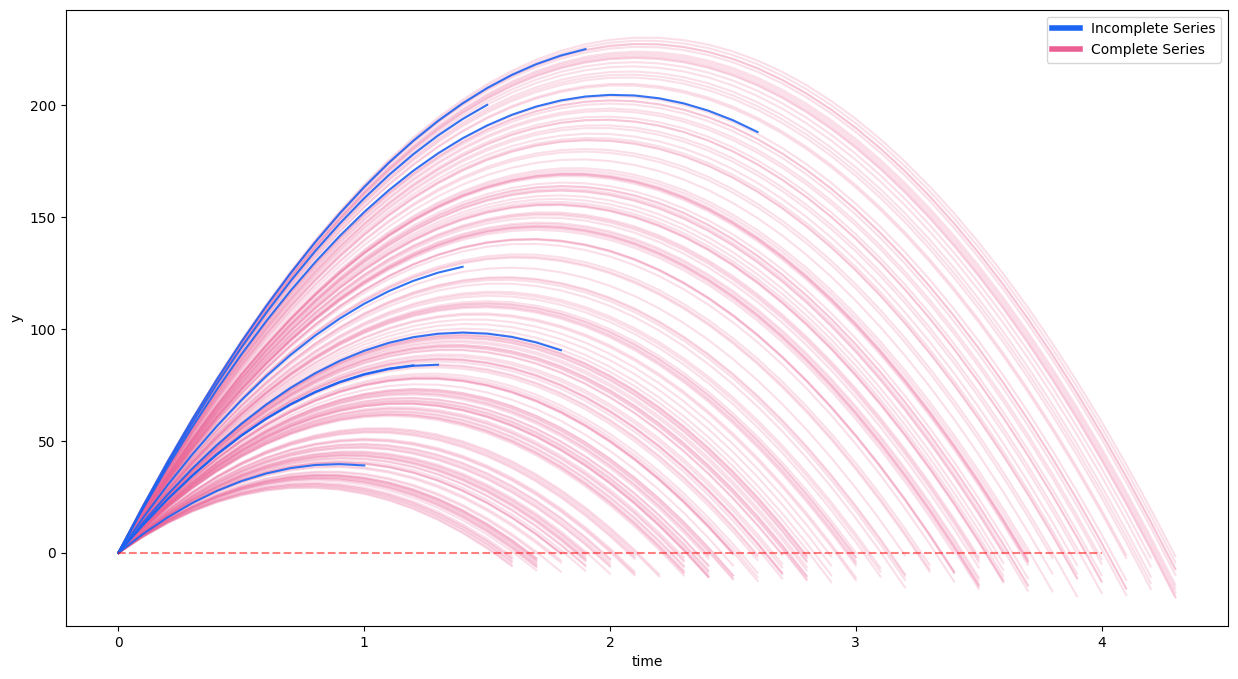

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(
    ax=ax,
    data=df[~df.id.isin(unfinished_ids)],
    x="time",
    y="y",
    units="id",
    estimator=None,
    color="#EA5F94",
    alpha=0.2,
)
sns.lineplot(
    ax=ax,
    data=df[df.id.isin(unfinished_ids)],
    x="time",
    y="y",
    units="id",
    estimator=None,
    color="#1C64F2",
    alpha=0.9,
)

legend_elements = [
    Line2D([0], [0], color="#1C64F2", lw=4, label="Incomplete Series"),
    Line2D([0], [0], color="#EA5F94", lw=4, label="Complete Series"),
]
ax.legend(handles=legend_elements)
plt.hlines([0], 0, 4, linestyles='--', colors='r', alpha=0.5)

## Step 2: Map Data

- Confirm the data types are detected correctly
- Specify the name of both the series ID feature and the time feature
- Specify the time feature to be **not universal**

One important feature attribute in time-series flows is 'universal'. This attribute can be found within the feature attributes under the "time_series" section of the attributes of the time feature. The attribute is a boolean flag that indicates whether the time feature should be treated as "universal" or not. When the time feature is universal, the Engine will not be able to use **any** data with a time value greater than the the time value of the data being predicted, in other words, it cannot use future data. If the time feature is **not** universal, then the Engine can use all of the data seen in other series, but still cannot use future data from the series it is making a prediction on. When this attribute is unspecified, the default behavior of the Engine is to treat the time feature as if it **is universal**.

The data presented in this notebook uses a time feature that is relative to each series. Each series starts at time 0 and it increases until the series ends. The time value isn't derived from any shared context, so we can set "universal" to be false in this example. In fact, we should do so to improve accuracy. Setting "universal" to false in this setting allows the Engine to leverage more of the trained data, without leaking external information relating to time. This is why we set the 'time_feature_is_universal' flag to false in our call to `infer_feature_attributes`.

In [4]:
# Identify id-feature and time-feature
id_feature_name = "id"
time_feature_name = "time"
features = infer_feature_attributes(
    df,
    time_feature_name=time_feature_name,
    id_feature_name=id_feature_name,
    time_feature_is_universal=False,
)
        
features

{'id': {'type': 'nominal',
  'original_type': {'data_type': 'integer', 'size': 8},
  'id_feature': True,
  'data_type': 'number',
  'bounds': {'allow_null': False}},
 'time': {'type': 'continuous',
  'decimal_places': 17,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 0.0, 'max': 7.389056098930651, 'allow_null': False},
  'time_series': {'type': 'delta',
   'time_feature': True,
   'universal': False,
   'delta_max': [0.27182818284590476],
   'delta_min': [0.0367879441171441]}},
 'y': {'type': 'continuous',
  'decimal_places': 17,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': -54.598150033144236, 'max': 403.4287934927351},
  'time_series': {'type': 'rate',
   'rate_max': [569.8462981526275],
   'rate_min': [-583.5594292609131]}}}

### Step 3: Build Trainee and make a time series prediction

The one change between regular analysis using non-time series data and time series data is that during the `train()` call, Engine calculates temporal information (deltas and rates) for each feature and adds these values in as additional features in your dataset.

This happens automatically if the feature attributes are configured properly.

In [5]:
t = Trainee(features=features)

# Training on the finished series data
t.train(df[~df.id.isin(unfinished_ids)])

## Step 4: Forecast the series data

To forecast the series, we will use the 'continue_series' flag as well as the 'continue_series_features' and 'continue_series_values' parameters to specify the series data we would like to forecast.

In [6]:
unfinished_series_df = df[df.id.isin(unfinished_ids)]
continue_series_values = [x[1] for x in unfinished_series_df.groupby('id')]

In [7]:
synth_df = t.react_series(
    continue_series_features=['id', 'time', 'y'],
    continue_series_values=continue_series_values,
    action_features=['id', 'time', 'y'],
    continue_series=True,
    output_new_series_ids=False,
)['action']

display(synth_df)

,.series,id,time,y
0,series_1,0,1.3,85.090837
1,series_1,0,1.4,85.375777
2,series_1,0,1.5,84.611201
3,series_1,0,1.6,82.785037
4,series_1,0,1.7,79.958510
...,...,...,...,...
132,series_8,160,2.3,37.053772
133,series_8,160,2.4,26.715512
134,series_8,160,2.5,15.377240
135,series_8,160,2.6,3.038956


## Step 6: Inspect the Forecast Data

It's usually helpful to inspect the forecasted data, so let's inspect the visualization of the forecasted data compared to the data that was used to make the forecasts.

We hope to see smooth arcs that simulate the path of the projectile until it hits the ground.

Of course, these forecasts may not be perfect, but we should see the general shape and the series should end near when they reach zero on the Y-axis.

In [8]:
last_cases_original = df.sort_values('time', ascending=False).drop_duplicates(['id'])
synth_df_with_lasts = pd.concat([synth_df, last_cases_original])

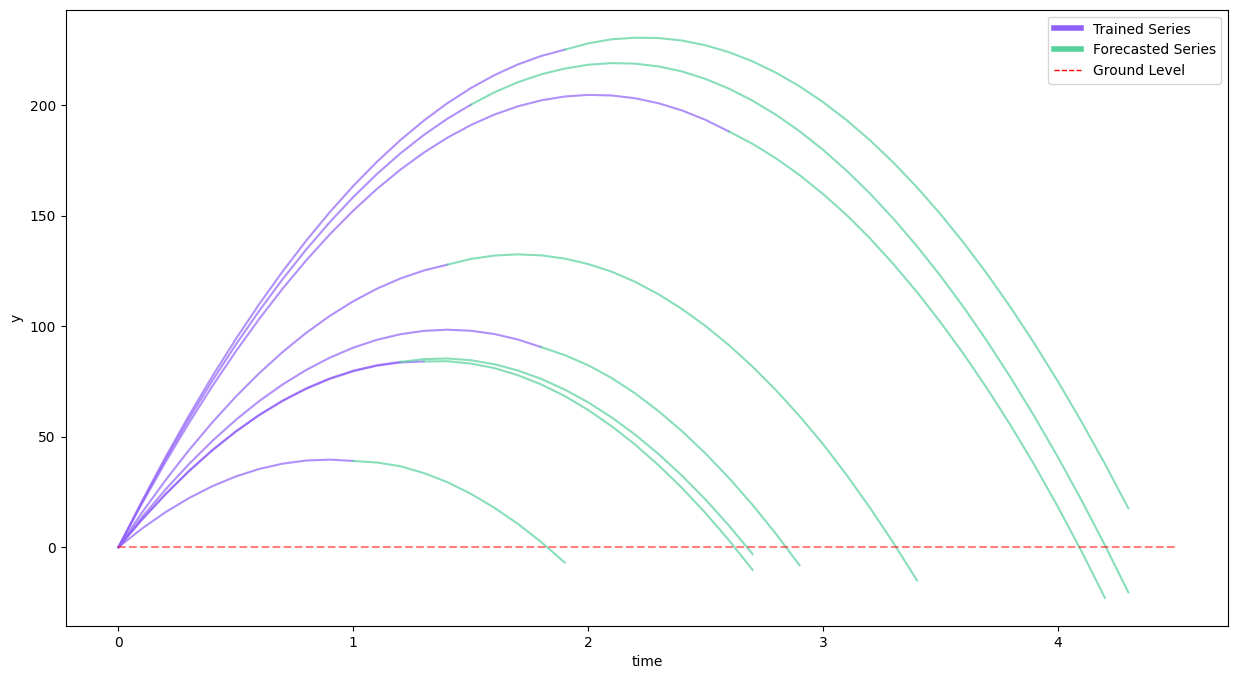

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(
    ax=ax,
    data=df[df.id.isin(unfinished_ids)],
    x="time",
    y="y",
    units="id",
    estimator=None,
    color="#9061F9",
    alpha=0.7,
)

sns.lineplot(
    ax=ax,
    data=synth_df_with_lasts,
    x="time",
    y="y",
    units="id",
    estimator=None,
    color="#56D19C",
    alpha=0.7,
)

legend_elements = [
    Line2D([0], [0], color="#9061F9", lw=4, label="Trained Series"),
    Line2D([0], [0], color="#56D19C", lw=4, label="Forecasted Series"),
    Line2D([0], [0], color='r', lw=1, linestyle='--', label='Ground Level')
]
ax.legend(handles=legend_elements)
plt.hlines([0], 0, 4.5, linestyles='--', colors='r', alpha=0.5)